In [1]:
using Printf
using Dates
using RandomNumbers
using StaticArrays
using LinearAlgebra
using Flux
using Plots
using Statistics

include("src/distances.jl");

# 1. Input configuration

`Use ; sign to run OS commands:`

In [2]:
;ls

algorithms
LICENSE
LJ-data.ipynb
LJ-init.in
LJML-init.in
LJ-test.in
mcLJ-run.jl
mctraj-p001.xyz
ML-IMC.ipynb
rdf-mean-p40.dat
README.md
src


This is the function that allows to read XYZ output files. I will use the coordinates as an input data for the training.

In [3]:
"""
readXYZ(xyzname)

Reads an XYZ file and outputs coordinates of all atoms
arranged in separate frames
"""
function readXYZ(xyzname)
    file = open(xyzname, "r")
    lines = readlines(file)
    natoms = parse(Int, lines[1])
    ncomments = 2
    nlines = length(lines)
    nframes = Int((nlines % natoms) / 2)
    xyz = [[zeros(3) for i in 1:natoms] for j in 1:nframes]
    println("Reading $(xyzname) with $(nlines) lines...")
    println("Found $(nframes) frames with $(natoms) atoms each...")
    for lineId in 1:nlines
        frameId = ceil(Int, lineId/(natoms + ncomments))
        atomId = lineId - ((frameId - 1) * (natoms + ncomments)) - ncomments
        @assert atomId <= natoms
        if atomId > 0
            atomLine = split(lines[lineId])
            for i in 1:3
                xyz[frameId][atomId][i] = parse(Float64, atomLine[i+1])
            end
        end
    end
    close(file)
    println("Success! Closing the file...")
    return(xyz)
end;

Reading the configurations:

In [4]:
xyz = readXYZ("mctraj-p001.xyz");

Reading mctraj-p001.xyz with 6012 lines...
Found 6 frames with 1000 atoms each...
Success! Closing the file...


Saving the final configuration:

In [5]:
confout = xyz[end];

# 2. Reference distance histogram

In [6]:
"""
readRDF(rdfname)

Reads RDF and distance histogram produced
by mcLJ.jl
"""
function readRDF(rdfname)
    file = open(rdfname, "r")
    lines = readlines(file)
    ncomments = 2
    nlines = length(lines) - ncomments
    bins = zeros(nlines)
    rdf = zeros(nlines)
    hist = zeros(nlines)
    for i in (1 + ncomments):length(lines)
        rdfline = split(lines[i])
        if length(rdfline) == 3
            bins[i - ncomments] = parse(Float64, rdfline[1])
            rdf[i - ncomments] = parse(Float64, rdfline[2])
            hist[i - ncomments] = parse(Float64, rdfline[3])
        end
    end
    return(bins, rdf, hist)
end;

In [7]:
bins, refrdf, refhist = readRDF("rdf-mean-p40.dat");

The reference distance histogram contains the average number of particle pairs within a given bin width in a single frame. The total number of pairs included in the reference histogram:

$$ \text{Reference: } N_{pairs} = \frac{N(N - 1)}{2} = 499500 $$

The number of pairs for a particle histogram:

$$ \text{Particle histogram: } N_{pairs} = N - 1 = 999 $$

$$ \frac{total}{particle} = \frac{499500}{999} = 500 $$

The values in the reference histogram should be divided by a factor of 500.

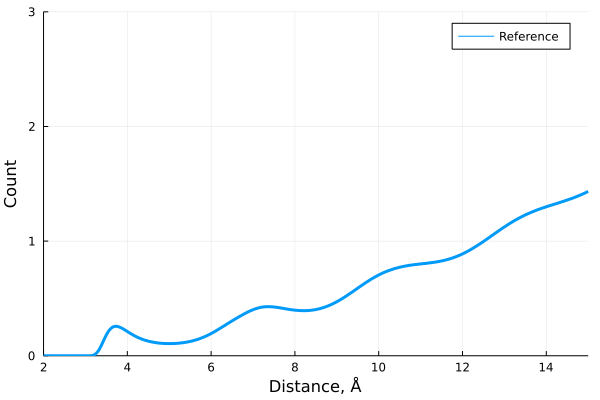

In [73]:
plot(bins, refhist./500, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("Count")

# 3. ML-IMC input parameters

In [9]:
"""
struct inputParms

Fields:
box: box vector, Å
β: 1/(kB*T), reciprocal kJ/mol
Δ: max displacement, Å
steps: total number of steps
Eqsteps: equilibration steps
xyzout: XYZ output frequency
outfreq: output frequency
binWidth: histogram bin width, Å
Nbins: number of histogram bins
"""
struct inputParms
    box::SVector{3, Float64}
    β::Float64
    Δ::Float64  
    steps::Int
    Eqsteps::Int
    xyzout::Int 
    outfreq::Int
    binWidth::Float64
    Nbins::Int
end;

In [10]:
"""
readinput(inputname)

Reads an input file for ML-IMC
and saves the data into the
inputParms struct
"""
function readinput(inputname)
    # Constants
    NA::Float64 = 6.02214076E23 # [mol-1]
    kB::Float64 = 1.38064852E-23 * NA / 1000 # [kJ/(mol*K)]
    # Has to define the variable outside of the main loop
    box = zeros(3)
    β::Float64 = 0.
    Δ::Float64 = 0.
    steps::Int = 0
    Eqsteps::Int = 0
    xyzout::Int = 0
    outfreq::Int = 0
    binWidth::Float64 = 0.
    Nbins::Int = 0
    file = open(inputname, "r")
    lines = readlines(file)
    for line in lines
        if length(line) > 0 && line[1] != '#'
            splittedLine = split(line)
            if splittedLine[1] == "box"
                box[1] = parse(Float64, splittedLine[3])
                box[2] = parse(Float64, splittedLine[4])
                box[3] = parse(Float64, splittedLine[5])
            elseif splittedLine[1] == "temperature"
                T = parse(Float64, splittedLine[3])
                β = 1/(kB * T)
            elseif splittedLine[1] == "delta"
                Δ = parse(Float64, splittedLine[3])
            elseif splittedLine[1] == "steps"
                steps = Int(parse(Float64, splittedLine[3]))
            elseif splittedLine[1] == "Eqsteps"
                Eqsteps = Int(parse(Float64, splittedLine[3]))
            elseif splittedLine[1] == "xyzout"
                xyzout = Int(parse(Float64, splittedLine[3]))
            elseif splittedLine[1] == "outfreq"
                outfreq = Int(parse(Float64, splittedLine[3]))
            elseif splittedLine[1] == "binWidth"
                binWidth = parse(Float64, splittedLine[3])
            elseif splittedLine[1] == "Nbins"
                Nbins = Int(parse(Float64, splittedLine[3]))
            end
        end
    end
    # Save parameters into the inputParms struct
    parameters = inputParms(box, β, Δ, steps, Eqsteps, xyzout, outfreq, binWidth, Nbins)
    return(parameters)
end;

In [11]:
parameters = readinput("LJML-init.in");

In [12]:
parameters.box

3-element SVector{3, Float64} with indices SOneTo(3):
 36.405
 36.405
 36.405

In [13]:
parameters.β

1.266025230073036

In [14]:
parameters.binWidth

0.025

# 4. Compute particle histogram

In [27]:
"""
function histpart!(distanceVector, hist, binWidth, recalculate=false)

Accumulates pair distances from a distance vector
(one particle) to a histogram
"""
function histpart!(distanceVector, hist, binWidth)
    N = length(distanceVector)
    @inbounds @fastmath for i in 1:N
        if distanceVector[i] != 0
            histIndex = floor(Int, 0.5 + distanceVector[i]/binWidth)
            if histIndex <= length(hist)
                hist[histIndex] += 1
            end
        end
    end
    return(hist)
end;

Initialize the distance vector for particle 1:

In [28]:
N = length(confout)
pointIndex = 1
distanceVector = zeros(N)
updatedistance!(confout, parameters.box, distanceVector, pointIndex);

Initialize the distance histogram:

In [34]:
maxR = maximum(bins)
binWidth = bins[2]
Nbins = length(bins)
hist = zeros(Nbins);

Compute the particle histogram:

In [35]:
histpart!(distanceVector, hist, binWidth);

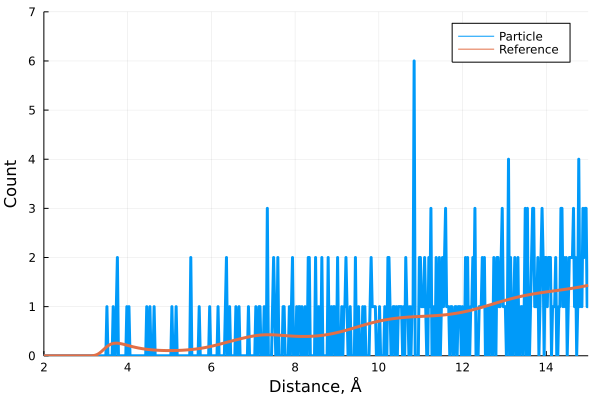

In [36]:
plot(bins, hist, xlim = (2, 15), ylim = (0, 7), linewidth=3, labels="Particle")
plot!(bins, refhist./500, xlim = (2, 15), ylim = (0, 7), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("Count")

# 5. Building the neural network

Initialize a net with `Nbins` neurons (600) in the input layer and 1 neuron in the output layer. One bias parameter is introduced. Hyperbolic tangent (tanh) is used as the activation function. I think tanh is a good option, because the result can be either negative or positive.

In [37]:
model = Dense(length(hist), 1, tanh, bias=true)

Dense(600, 1, tanh)  # 601 parameters

Network weigths (potential parameters):

In [38]:
model.weight

1×600 Matrix{Float32}:
 -0.0898014  -0.0711928  0.0118711  …  -0.095134  -0.0508004  0.0166153

In [39]:
model.bias

1-element Vector{Float32}:
 0.0

Use the model to predict energy from the particle histogram:

In [40]:
E = model(hist)

1-element Vector{Float64}:
 -0.6687722561226652

# 6. Neural network Monte Carlo

In [41]:
"""
neuralenergy(hist, model)

Computes the potential energy of one particle
distance histogram using the neural network
"""
function neuralenergy(hist, model)
    E::Float64 = model(hist)[1]
    return(E)
end;

In [42]:
neuralenergy(hist, model)

-0.6687722561226652

Now I need to write the function for MC moves. One important aspect here is that I need to sample particle histograms very frequently (around 500 times more often than with the total histogram).

In [53]:
function mcmove!(conf, parameters, model, histNN, rng)
    # Pick a particle
    pointIndex = rand(rng, Int32(1):Int32(length(conf)))
    
    # Allocate and compute the distance vector
    distanceVector = zeros(length(conf))
    updatedistance!(conf, parameters.box, distanceVector, pointIndex)
    
    # Allocate and compute the histogram
    hist1 = zeros(parameters.Nbins)
    histpart!(distanceVector, hist1, parameters.binWidth)
    
    # Compute the energy
    E1 = neuralenergy(hist1, model)
    
    # Displace the particle
    dr = SVector{3, Float64}(parameters.Δ*(rand(rng, Float64) - 0.5), 
                             parameters.Δ*(rand(rng, Float64) - 0.5), 
                             parameters.Δ*(rand(rng, Float64) - 0.5))
    
    conf[pointIndex] += dr
    
    # Update distance and compute the new histogram
    hist2 = zeros(parameters.Nbins)
    updatedistance!(conf, parameters.box, distanceVector, pointIndex)
    histpart!(distanceVector, hist2, parameters.binWidth)
    
    # Compute the energy again
    E2 = neuralenergy(hist2, model)
    
    # Get energy difference
    ΔE = E2 - E1
    # Acceptance counter
    accepted = 0
    
    if rand(rng, Float64) < exp(-ΔE*parameters.β)
        accepted += 1
        # Add the new particle histogram to the total histogram
        histpart!(distanceVector, histNN, parameters.binWidth)
    else
        conf[pointIndex] -= dr
        # Don't add anything to the histogram?
    end
    return(conf, histNN, accepted)
end

mcmove! (generic function with 1 method)

I need to decide how I accumulate the histograms. It makes sense to accumulate them if I compute them, but I also need a possibility to recompute them. Also, I need to decide whether I use the distance matrix or not.

I think I have come up with a way - I need to allocate three histograms: two intermediates and one accumulator.

# 6.1 Running a few moves

Checking/initializing some of the inputs...

In [49]:
confout = xyz[end]

1000-element Vector{Vector{Float64}}:
 [48.997, 68.367, 42.68]
 [-149.988, -59.816, 39.975]
 [-18.002, 19.492, 8.101]
 [40.034, -11.053, 36.059]
 [40.986, 16.502, -32.82]
 [11.065, 44.013, 34.926]
 [-40.697, -2.878, 4.796]
 [-7.023, -88.156, -14.235]
 [24.272, 22.657, 11.551]
 [28.697, 23.566, -19.265]
 [69.193, 1.745, 43.079]
 [-10.315, 52.748, -60.018]
 [3.72, 22.04, 40.387]
 ⋮
 [21.852, 44.564, 37.842]
 [49.351, 23.293, 77.622]
 [-54.123, 26.128, -46.036]
 [118.212, 54.391, -3.574]
 [23.553, -14.886, -15.804]
 [26.408, -1.202, 7.283]
 [108.861, 40.892, 60.142]
 [54.721, 8.452, -19.006]
 [-2.897, 61.803, 63.72]
 [84.18, 18.61, -51.396]
 [58.957, 105.051, -7.132]
 [102.297, 20.58, -17.567]

In [46]:
parameters

inputParms([36.405, 36.405, 36.405], 1.266025230073036, 0.75, 1000000, 100000, 1000000, 100000, 0.025, 600)

In [45]:
rng_xor = RandomNumbers.Xorshifts.Xoroshiro128Plus()

RandomNumbers.Xorshifts.Xoroshiro128Plus(0x5022ce6af6a7383b, 0x1474ea2338b6323d)

In [47]:
model

Dense(600, 1, tanh)  # 601 parameters

In [57]:
histNN = zeros(parameters.Nbins)

600-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [63]:
acceptedTotal = 0
@time for step in 1:parameters.steps
    conf, histNN, accepted = mcmove!(confout, parameters, model, histNN, rng_xor)
    acceptedTotal += accepted
end

 47.864541 seconds (19.21 M allocations: 17.361 GiB, 1.17% gc time)


In [64]:
acceptedTotal/parameters.steps

0.788423

In [66]:
histNN./1E6

600-element Vector{Float64}:
 1.2e-5
 3.2e-5
 6.1e-5
 9.2e-5
 0.000163
 0.000211
 0.000311
 0.000406
 0.000537
 0.000609
 0.000704
 0.000908
 0.001099
 ⋮
 2.188316
 2.225961
 2.228079
 2.280055
 2.216964
 2.229496
 2.245099
 2.297516
 2.340144
 2.353583
 2.332544
 2.29635

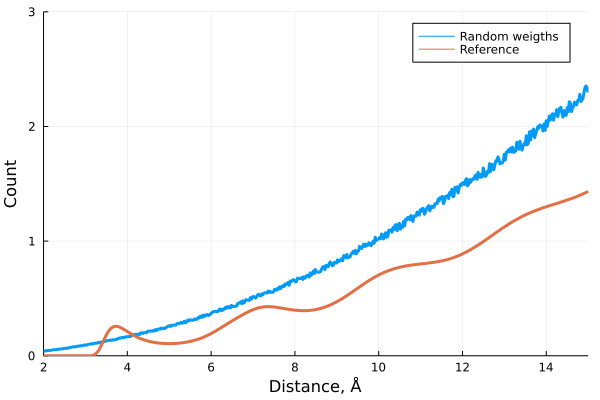

In [74]:
plot(bins, histNN./1E6, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Random weigths")
plot!(bins, refhist./500, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("Count")